In [2]:
## Vigilant Asset Allocation

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [4]:
# 시각화 관련 ##
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [5]:
##절대경로 참조
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))

from library.quant_functions import anal_funcs, data_funcs

In [6]:
## 조건1. 판단기준 -> 1개월*12, 3개월*4, 6개월*2 평균, 12개월*1
## 조건2. 공격자산 중 하나라도 (-)진입시 수비자산 전환
## 조건3. 모든 포지션에서 판단기준값이 가장 높은 자산 투자
## 조건4. 월단위 리벨런싱

## Func

In [7]:
### 1개월 수익률, 3개월 수익률, 6개월 수익률의 가중평균 산출함수
def get_wapr(close):
    ## 월단위 데이터를 기준으로함
    ## get_signal()로 이어짐
    df_cls = close.copy()
    pr1 = np.log(df_cls/df_cls.shift(1))
    pr3 = np.log(df_cls/df_cls.shift(3))
    pr6 = np.log(df_cls/df_cls.shift(6))
    pr12 = np.log(df_cls/df_cls.shift(12))
    df_pr = pd.concat([pr1, pr3*(4/12), pr6*(2/12), pr12*(1/12)], axis = 1)
    mpr = df_pr.mean(axis=1)
    return mpr

def get_signal(df):
    ## 금리2% 1개월 무위험수익률 ## 향후 기준금리 데이터 반영 가능
    nrr = (1.02**(1/12))-1
    ## get_strategy_value()로 이어짐

    signal_df = df.copy()
    for cols in signal_df.columns:
        signal_df[cols] = get_wapr(signal_df[cols])
    signal_df = signal_df.dropna()

    atks= signal_df[signal_df.columns[:4]].T
    dfcs= signal_df[signal_df.columns[4:]].T
    
    ## 판단로직
    signal_df['diretion'] = 'bear'
    signal_df['diretion'][(signal_df[signal_df.columns[0]] > nrr)&(signal_df[signal_df.columns[1]] > nrr)&
                       (signal_df[signal_df.columns[2]] > nrr)&(signal_df[signal_df.columns[3]] > nrr)] = 'bull'

    optimal_ticker = []
    for i in range(len(signal_df)):
        if signal_df['diretion'][i] == 'bull':
            optimal_ticker.append(atks[atks[atks.columns[i]] == atks[atks.columns[i]].max()].index.values[0])
        elif signal_df['diretion'][i] == 'bear':
            optimal_ticker.append(dfcs[dfcs[dfcs.columns[i]] == dfcs[dfcs.columns[i]].max()].index.values[0])

    signal_df['signal'] = optimal_ticker
    
    new_df = df.copy()
    new_df['signal'] = signal_df['signal']
    new_df['prev'] = new_df['signal'].shift(1)
    
    new_df['change'] = 0
    new_df['change'][new_df['signal'] != new_df['prev']] = 1
    new_df = new_df.dropna()
    
    return new_df, signal_df



def get_strategy_value(df):
    new_df, _ = get_signal(df)
    ## 시그널발생시 자산 교환 비율 산출
    new_df['exchange_rate'] = 1.0
    for i in range(len(new_df)):
        if (new_df['change'][i] == 1)&(type(new_df['prev'][i]) == str):
            new_df['exchange_rate'][i] = new_df[new_df['prev'][i]][i]/new_df[new_df['signal'][i]][i]         
    ## 누적 교환비 산출
    new_df['cum_exchange_rate'] = new_df['exchange_rate']
    for i in range(len(new_df)):
        new_df['cum_exchange_rate'][i] = new_df['exchange_rate'][:i+1].product()
    ## 자산추이
    new_df['strategy'] = 1.0
    for i in range(len(new_df)):
        new_df['strategy'][i] = new_df[new_df['signal'][i]][i]*new_df['cum_exchange_rate'][i]
        
    result = new_df.drop(columns=['change', 'exchange_rate', 'cum_exchange_rate'])
        
    return result

## Proc

In [8]:
## X3 VAA전략 ## 확정전
## df = get_merged_df('TQQQ', 'UPRO', 'EURL', 'EDC', 'TMF', 'TYD', 'BNKU')
## df['CASH'] = 1 ## SHY 대용 CASH
df = data_funcs.get_merged_df('SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY')
df = df[['SPY', 'QQQ', 'VEA', 'VWO', 'TLT', 'IEF', 'SHY']]
df = df[['SPY', 'QQQ', 'VEA', 'VWO', 'SHY']]

dataset = df.dropna()
## dataset = dataset[dataset.index >= '2010-10-01']

[*********************100%%**********************]  7 of 7 completed


In [9]:
df = dataset.resample('M').last()
df = df[:].copy()
df['SHY'] = 1

In [10]:
strategy_df_result = get_strategy_value(df)

result_df = strategy_df_result.copy()
temp = result_df[['SPY', 'QQQ', 'VEA', 'VWO', 'SHY', 'strategy']]
result_df[['SPY', 'QQQ', 'VEA', 'VWO', 'SHY', 'strategy']] = temp/np.array(temp)[0]

_, signal_df = get_signal(df)

## Report

In [11]:
## 기하수익률
np.log(strategy_df_result[strategy_df_result.columns[:-3]]/strategy_df_result[strategy_df_result.columns[:-3]].shift(1)).tail(6)

,SPY,QQQ,VEA,VWO,SHY
Date,,,,,
2023-04-30,0.015849,0.005066,0.026004,-0.003968,0.0
2023-05-31,0.004606,0.075885,-0.038031,-0.030019,0.0
2023-06-30,0.062787,0.061131,0.043337,0.046321,0.0
2023-07-31,0.032209,0.037875,0.030916,0.057090,0.0
2023-08-31,-0.016386,-0.014941,-0.040271,-0.060784,0.0
2023-09-30,-0.002468,0.000212,-0.007459,0.004922,0.0


In [12]:
## 최근 상대 수준
strategy_df_result.tail(6)

,SPY,QQQ,VEA,VWO,SHY,signal,prev,strategy
Date,,,,,,,,
2023-04-30,414.390686,322.118134,45.935596,40.022202,1,SHY,QQQ,2.324710
2023-05-31,416.303619,347.513306,44.221436,38.838642,1,SHY,SHY,2.324710
2023-06-30,443.279999,369.420013,46.180000,40.680000,1,QQQ,SHY,2.324710
2023-07-31,457.790009,383.679993,47.630001,43.070000,1,QQQ,QQQ,2.414446
2023-08-31,450.350006,377.989990,45.750000,40.529999,1,SHY,QQQ,2.378639
2023-09-30,449.239990,378.070007,45.410000,40.730000,1,QQQ,SHY,2.378639


In [13]:
## 시그널 근거
signal_df.tail(6)

,SPY,QQQ,VEA,VWO,SHY,diretion,signal
Date,,,,,,,
2023-04-30,0.010181,0.016081,0.017591,0.000224,0.0,bear,SHY
2023-05-31,0.007863,0.043238,-0.006284,-0.010593,0.0,bear,SHY
2023-06-30,0.032797,0.046787,0.021123,0.014897,0.0,bull,QQQ
2023-07-31,0.024152,0.039396,0.015682,0.023075,0.0,bull,QQQ
2023-08-31,0.011159,0.018937,-0.002096,-0.009791,0.0,bear,SHY
2023-09-30,0.009550,0.016203,0.002481,0.004654,0.0,bull,QQQ


In [14]:
test_dfs = [result_df.reset_index().shift(i).set_index('Date')[-(len(result_df)+1 - int(len(result_df)/10)):]
            for i in range(int(len(result_df)/10))]

In [15]:
CAGR = np.mean([anal_funcs.get_ACI_CAGR(test_dfs[i]['strategy']) for i in range(len(test_dfs))])
print(f'적립식 수행시, 누적 시뮬레이션 수익률: {CAGR.round(2)}%')

적립식 수행시, 누적 시뮬레이션 수익률: 58.12%


In [16]:
RPP = np.mean([anal_funcs.get_ACI_RPP(test_dfs[i]['strategy']) for i in range(len(test_dfs))])
print(f'적립식 수행시, 월평균 시뮬레이션 수익률: {RPP.round(2)}%')

적립식 수행시, 월평균 시뮬레이션 수익률: 0.52%


In [17]:
## 연수익률
anal_funcs.get_YTD_report(result_df, 'a')

,SPY,QQQ,VEA,VWO,SHY,strategy
Date,,,,,,
2008,-36.79,-41.73,-40.62,-52.46,0.0,-8.00
2009,26.35,54.68,27.51,76.31,0.0,38.81
2010,15.06,20.14,8.35,19.48,0.0,-6.63
2011,1.90,3.48,-12.31,-18.75,0.0,-9.72
2012,15.99,18.11,18.56,19.21,0.0,15.68
2013,32.31,36.63,21.81,-4.94,0.0,9.51
2014,13.46,19.18,-5.97,-0.04,0.0,1.23
2015,1.23,9.44,-0.37,-15.82,0.0,-5.83
2016,12.00,7.10,2.63,12.17,0.0,2.62


In [18]:
## 전고점대비 최대낙폭(MDD)
MDD, HRR = anal_funcs.get_MDD_report(result_df, 'a')
MDD

,MDD(%),Date
Ticker,,
SPY,-50.78,2009-02-28
QQQ,-49.74,2009-02-28
VEA,-57.05,2009-02-28
VWO,-61.69,2009-02-28
SHY,0.00,2007-09-30
strategy,-16.33,2011-11-30


In [19]:
## sortino ratio
sort_df = anal_funcs.get_Vol_report(test_dfs[0], 'g', unit='monthly', rf=3)
## 모든 가능한 시작 시점에 대한 평가
temp = ([anal_funcs.get_Vol_report(test_dfs[i], 'g', unit='monthly', rf=3) for i in range(len(test_dfs))])
sort_df_simulation = (sum(temp)/len(temp)).round(2)

In [20]:
sort_df_simulation

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
SPY,6.55,4.57,3.54,0.00,1.00,0.78,1.03,3.55,0.00,NaN
QQQ,8.23,5.33,3.77,2.13,0.79,0.98,1.41,6.65,2.44,0.79
VEA,3.15,5.29,4.01,2.36,0.77,0.04,0.07,0.19,-2.59,-1.44
VWO,2.44,6.10,4.59,3.96,0.57,-0.08,-0.07,-0.97,-2.58,-1.03
SHY,0.00,0.00,NaN,4.57,NaN,-inf,NaN,NaN,NaN,-1.44
strategy,4.43,2.99,2.35,4.39,0.59,0.48,0.62,2.44,-0.64,-0.49


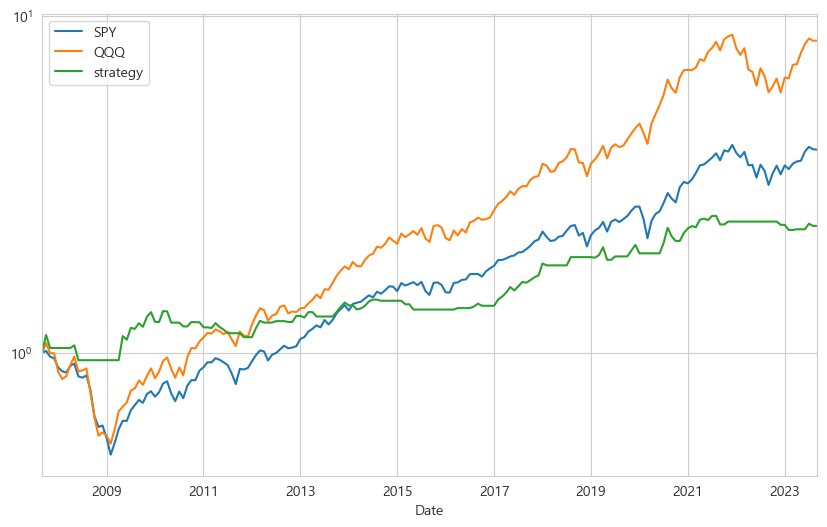

In [21]:
result_df[['SPY', 'QQQ', 'strategy']].plot()
plt.yscale('log')

<Axes: xlabel='Date'>

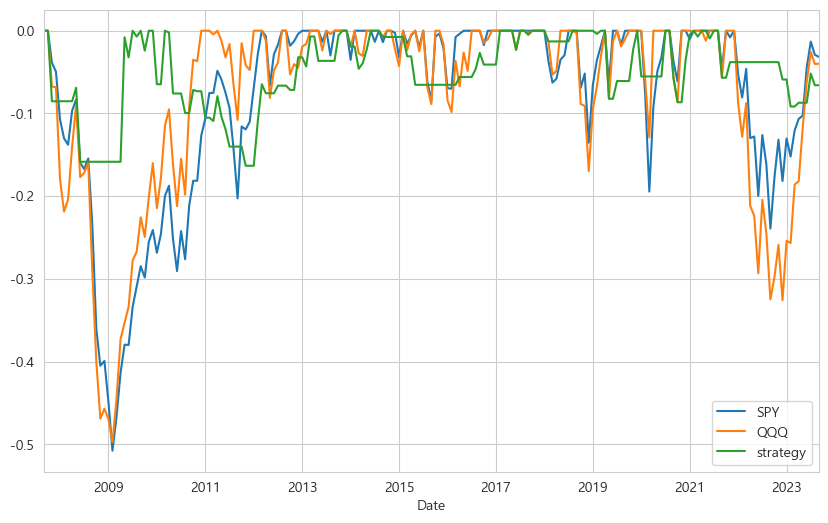

In [22]:
HRR[['SPY', 'QQQ', 'strategy']].plot()